In [9]:
!pip install numpy pandas scikit-learn tensorflow matplotlib


In [10]:
from google.colab import files
uploaded = files.upload()


Saving exoTrain.csv to exoTrain.csv


In [11]:
import os

if os.path.exists("exoTrain.csv"):
    os.rename("exoTrain.csv", "kepler.csv")

print(os.listdir())


['.config', 'best_model.h5', 'kepler.csv', 'best_model.keras', 'exoplanet_app.py', 'sample_data']


In [12]:
import pandas as pd

df = pd.read_csv("kepler.csv")
df.head()


,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


In [13]:
import pandas as pd

df = pd.read_csv("kepler.csv")
df.head()


,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


In [14]:
print("Dataset shape:", df.shape)
print(df["LABEL"].value_counts())


Dataset shape: (5087, 3198)
LABEL
1    5050
2      37
Name: count, dtype: int64


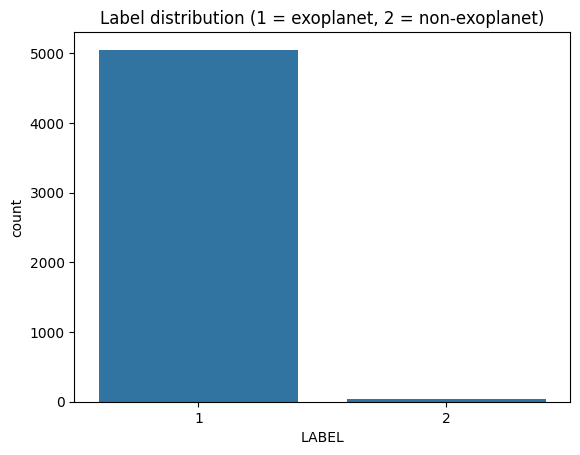

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x="LABEL", data=df)
plt.title("Label distribution (1 = exoplanet, 2 = non-exoplanet)")
plt.show()


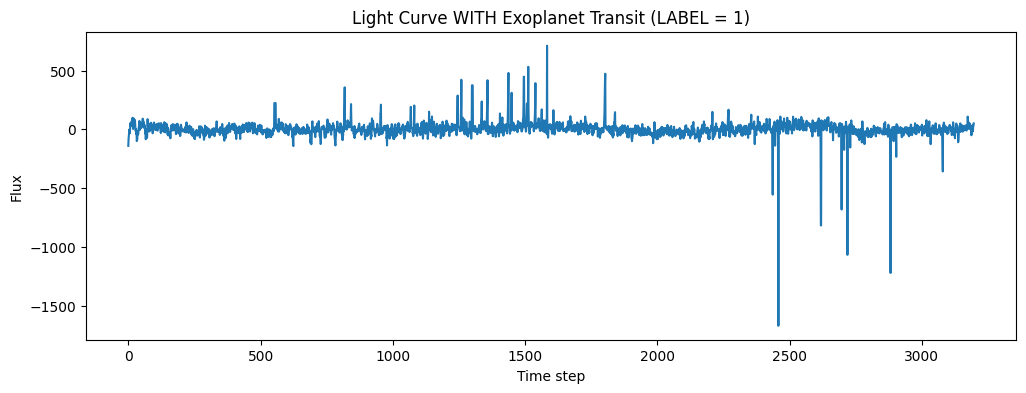

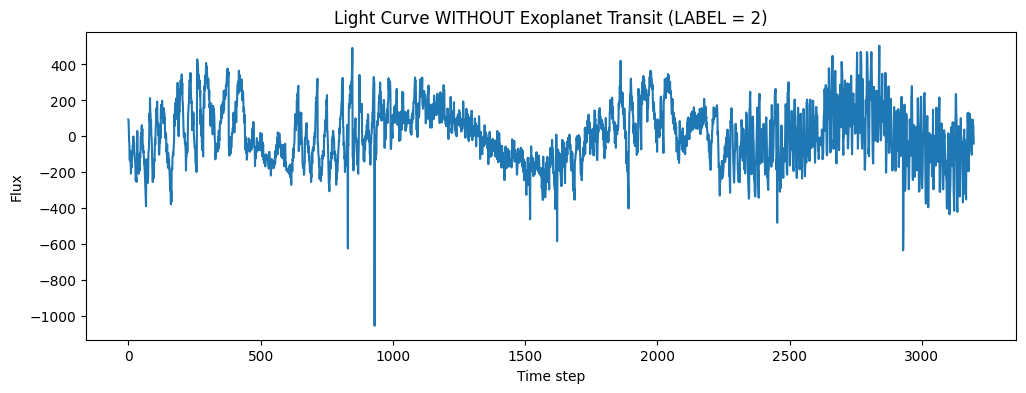

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Pick one example of each class
pos = df[df["LABEL"] == 1].iloc[0]   # exoplanet sample
neg = df[df["LABEL"] == 2].iloc[0]   # non-exoplanet sample

pos_curve = pos.drop(labels=["LABEL"]).values
neg_curve = neg.drop(labels=["LABEL"]).values

plt.figure(figsize=(12,4))
plt.plot(pos_curve)
plt.title("Light Curve WITH Exoplanet Transit (LABEL = 1)")
plt.xlabel("Time step"); plt.ylabel("Flux")
plt.show()

plt.figure(figsize=(12,4))
plt.plot(neg_curve)
plt.title("Light Curve WITHOUT Exoplanet Transit (LABEL = 2)")
plt.xlabel("Time step"); plt.ylabel("Flux")
plt.show()


In [17]:
# Preprocess data for training
from scipy.signal import savgol_filter
from sklearn.model_selection import train_test_split
import numpy as np

def preprocess_lightcurves(df, smooth=True, window=11, poly=3):
    """
    df: DataFrame with LABEL + flux columns
    Returns: X (N, T, 1), y (N,)
    """
    # labels: convert 1 → 1, 2 → 0
    y_raw = df["LABEL"].values.astype("float32")
    y = np.where(y_raw == 1.0, 1.0, 0.0)

    X = df.drop(columns=["LABEL"]).values.astype("float32")   # (N, T)

    # optional smoothing
    if smooth:
        X_smooth = []
        for row in X:
            # savgol smoothing requires odd window
            w = min(window, len(row) - 1)
            if w % 2 == 0:
                w -= 1
            if w < 3:
                X_smooth.append(row)
                continue
            X_smooth.append(savgol_filter(row, w, poly))
        X = np.stack(X_smooth)

    # normalize each sample
    mean = X.mean(axis=1, keepdims=True)
    std = X.std(axis=1, keepdims=True) + 1e-6
    X = (X - mean) / std

    # add channel dimension for CNN
    X = X[..., np.newaxis]   # (N, T, 1)

    return X, y


# run preprocessing
X, y = preprocess_lightcurves(df)
X.shape, y.shape


((5087, 3197, 1), (5087,))

In [18]:
# Split training/validation datasets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_val.shape


((4069, 3197, 1), (1018, 3197, 1))

In [19]:
# Build the 1D-CNN model
import tensorflow as tf
from tensorflow.keras import layers, models

def build_exoplanet_cnn(input_length):
    model = models.Sequential([
        layers.Conv1D(32, kernel_size=7, padding='same', activation='relu', input_shape=(input_length, 1)),
        layers.MaxPooling1D(pool_size=2),

        layers.Conv1D(64, kernel_size=7, padding='same', activation='relu'),
        layers.MaxPooling1D(pool_size=2),

        layers.Conv1D(128, kernel_size=7, padding='same', activation='relu'),
        layers.MaxPooling1D(pool_size=2),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

model = build_exoplanet_cnn(X_train.shape[1])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 3197, 32)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1598, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1598, 64)       │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 799, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 799, 128)       │        57,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 399, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51072)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,537,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,609,601 (25.21 MB)

 Trainable params: 6,609,601 (25.21 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Train the model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint(
    "best_model.h5",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=6,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=40,
    batch_size=256,
    callbacks=[checkpoint, early_stop],
    verbose=1
)


Epoch 1/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 574ms/step - accuracy: 0.9345 - loss: 0.2201
Epoch 1: val_accuracy improved from -inf to 0.99312, saving model to best_model.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 777ms/step - accuracy: 0.9369 - loss: 0.2135 - val_accuracy: 0.9931 - val_loss: 0.0534
Epoch 2/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9913 - loss: 0.0592
Epoch 2: val_accuracy did not improve from 0.99312
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - accuracy: 0.9914 - loss: 0.0584 - val_accuracy: 0.9931 - val_loss: 0.0369
Epoch 3/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9927 - loss: 0.0393
Epoch 3: val_accuracy did not improve from 0.99312
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - accuracy: 0.9927 - loss: 0.0392 - val_accuracy: 0.9931 - val_loss: 0.0322
Epoch 4/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9914 - loss: 0.0378
Epoch 4: val_accuracy did not improve from 0.99312
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - accuracy: 0.9915 - loss: 0.0375 - val_accuracy: 0.9931 - val_loss: 0.0310
Epoch 5/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9926 - loss: 0.0233
Epoch 5: val_accuracy did not impr

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step - accuracy: 0.9924 - loss: 0.0065 - val_accuracy: 0.9941 - val_loss: 0.0238
Epoch 12/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9957 - loss: 0.0069
Epoch 12: val_accuracy did not improve from 0.99411
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - accuracy: 0.9958 - loss: 0.0069 - val_accuracy: 0.9941 - val_loss: 0.0222
Epoch 13/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9981 - loss: 0.0056
Epoch 13: val_accuracy did not improve from 0.99411
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.9980 - loss: 0.0057 - val_accuracy: 0.9941 - val_loss: 0.0220
Epoch 14/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9985 - loss: 0.0063
Epoch 14: val_accuracy did not improve from 0.99411
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - accuracy: 0.9984 - loss: 0.0062 - val_accuracy: 0.9941 - val_loss: 0.0266


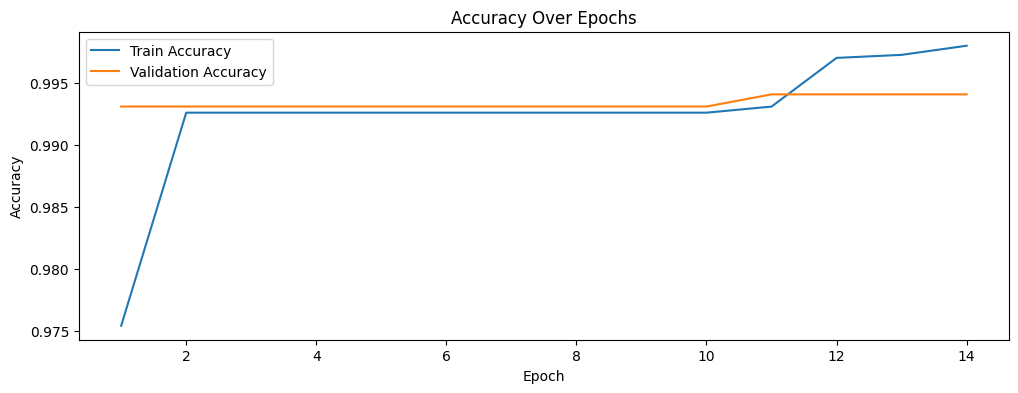

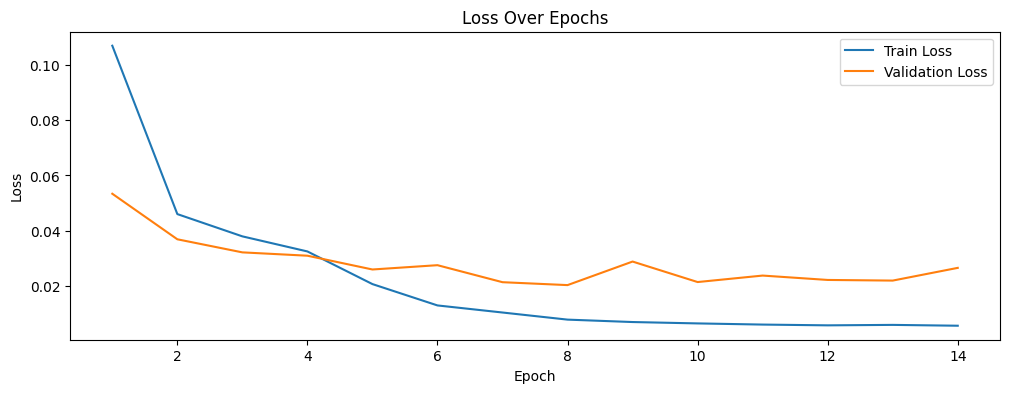

In [21]:
# Plot Accuracy & Loss Curves
import matplotlib.pyplot as plt

epochs = range(1, len(history.history['accuracy']) + 1)

plt.figure(figsize=(12,4))
plt.plot(epochs, history.history['accuracy'], label='Train Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(epochs, history.history['loss'], label='Train Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [22]:
# Evaluation (Confusion Matrix + Classification Report)
from tensorflow.keras.models import load_model

best_model = load_model("best_model.h5")
val_pred = best_model.predict(X_val)
val_pred_binary = (val_pred > 0.5).astype("int32")


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

acc = accuracy_score(y_val, val_pred_binary)
prec = precision_score(y_val, val_pred_binary)
rec = recall_score(y_val, val_pred_binary)
f1 = f1_score(y_val, val_pred_binary)

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")


Accuracy:  0.9941
Precision: 0.9941
Recall:    1.0000
F1 Score:  0.9970


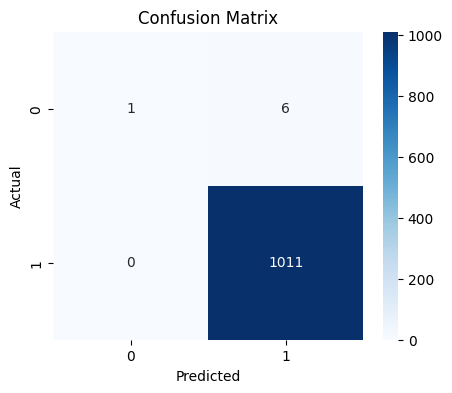

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_val, val_pred_binary)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [25]:
# Test with a sample
sample = X_val[0]
prob = best_model.predict(sample.reshape(1, -1, 1))[0][0]

print("Predicted Probability:", prob)
print("Prediction:", "Exoplanet" if prob > 0.5 else "No Exoplanet")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step
Predicted Probability: 1.0
Prediction: Exoplanet


In [26]:
!pip install streamlit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 110.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 147.3 MB/s eta 0:00:00


In [27]:
# Creating the Streamlit app file in Colab
%%writefile exoplanet_app.py
import numpy as np
import pandas as pd
import streamlit as st
from tensorflow.keras.models import load_model

MODEL_PATH = "best_model.keras"

@st.cache_resource
def load_exoplanet_model():
    return load_model(MODEL_PATH)

def preprocess_lightcurve(arr: np.ndarray) -> np.ndarray:
    # normalize: (x - mean) / std
    mean = arr.mean()
    std = arr.std() + 1e-6
    arr = (arr - mean) / std
    return arr.reshape(1, -1, 1)   # (1, timesteps, 1)

st.title("🔭 Exoplanet Detector – NASA Kepler Light Curves")
st.write("Upload a CSV file containing **one row** of flux values (no label).")

uploaded = st.file_uploader("Upload light-curve CSV", type=["csv"])

if uploaded is not None:
    df = pd.read_csv(uploaded, header=None)
    lc = df.values.flatten().astype("float32")

    st.subheader("Light Curve")
    st.line_chart(lc)

    x = preprocess_lightcurve(lc)
    model = load_exoplanet_model()

    prob = float(model.predict(x)[0][0])
    pred = "🟢 Exoplanet Candidate" if prob > 0.5 else "🔴 No Exoplanet"

    st.subheader("Result")
    st.write(f"**Prediction:** {pred}")
    st.write(f"**Probability score:** `{prob:.4f}`")


Overwriting exoplanet_app.py


In [28]:
# Creating a sample light-curve CSV to test with
import pandas as pd
import numpy as np

# take first sample from validation set
sample_curve = X_val[0].squeeze()   # shape (T,)
# save as one-row CSV
pd.DataFrame([sample_curve]).to_csv("sample_lightcurve.csv", index=False, header=False)

print("Saved sample_lightcurve.csv")


Saved sample_lightcurve.csv


In [29]:
!npm install -g localtunnel


⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹
added 22 packages in 3s
⠹
⠹3 packages are looking for funding
⠹  run `npm fund` for details
⠹

In [30]:
import threading, time, subprocess

def run_streamlit():
    subprocess.run(["streamlit", "run", "exoplanet_app.py", "--server.port", "8501"])

thread = threading.Thread(target=run_streamlit)
thread.start()

time.sleep(20)  # give Streamlit time to start

# expose the app via localtunnel
!lt --port 8501


your url is: https://silly-dingos-tie.loca.lt
^C


In [31]:
!lt --port 8501 --print-requests


your url is: https://hungry-hands-move.loca.lt
^C


In [40]:
!lt --port 8501 --subdomain exoplanetai


your url is: https://exoplanetai.loca.lt
/tools/node/lib/node_modules/localtunnel/bin/lt.js:81
    throw err;
    ^

Error: connection refused: localtunnel.me:17199 (check your firewall settings)
    at Socket.<anonymous> (/tools/node/lib/node_modules/localtunnel/lib/TunnelCluster.js:52:11)
    at Socket.emit (node:events:524:28)
    at emitErrorNT (node:internal/streams/destroy:169:8)
    at emitErrorCloseNT (node:internal/streams/destroy:128:3)
    at process.processTicksAndRejections (node:internal/process/task_queues:82:21)

Node.js v20.19.0


In [33]:
from google.colab import files
files.download("best_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [34]:
from google.colab import files
files.download("exoplanet_app.py")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [35]:
from google.colab import files
files.download("sample_lightcurve.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [36]:
from google.colab import files
uploaded = files.upload()


Saving best_model.h5 to best_model (1).h5


In [37]:
!ls


'best_model (1).h5'   best_model.keras	 kepler.csv    sample_lightcurve.csv
 best_model.h5	      exoplanet_app.py	 sample_data


In [38]:
from tensorflow.keras.models import load_model

model = load_model("best_model.h5")
model.save("best_model.keras", include_optimizer=False)
# Convert to .keras format

In [39]:
from google.colab import files
files.download("best_model.keras")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>